In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing_extensions import List
from scipy.signal import find_peaks

@dataclass
class PeakData:

    index: str
    x: np.ndarray
    y: np.ndarray

    @property
    def time_diff(self) -> List[int]:
        deltas = []
        for i in range(len(self.x)-1):
            deltas.append(self.x[i+1] - self.x[i])
        return np.array(deltas, dtype=float)

@dataclass
class Peaks:

    good: List[PeakData]
    less: List[PeakData]
    more: List[PeakData]

@dataclass
class MuonDecayEvents:

    df: pd.DataFrame

    @property
    def scale(self) -> float:
        """mu-sec/div"""
        return 1E-6

    @property
    def number_divisions(self) -> int:
        return 10

    @property
    def number_adc_channels(self) -> int:
        return len(self.df.columns)

    @property
    def time_data(self) -> np.ndarray:
        data = np.array([i for i in range(self.number_adc_channels)])
        return self.convert_time_to_units(time_data=data)

    def convert_time_to_units(self, time_data: np.ndarray) -> np.ndarray:
        k = self.number_divisions / self.number_adc_channels
        return k * time_data

    def find_peaks(self, height: float = -10., distance: int = 10, invert_data: bool = False) -> Peaks:
        k = -1 if invert_data else 1
        good = []
        less = []
        more = []
        for index in self.df.index:
            x_peaks, y_peaks = find_peaks(x=k*self.df.loc[index], height=height, distance=distance)
            peaks = PeakData(
                index = index,
                x     = self.convert_time_to_units(x_peaks), 
                y     = k*y_peaks['peak_heights'],
            )
            if len(x_peaks) == 2:
                good.append(peaks)
            elif len(x_peaks) < 2:
                less.append(peaks)
            elif len(x_peaks) > 2:
                more.append(peaks)
        return Peaks(good=good, less=less, more=more)

    def plot_event(self, peaks_data: PeakData) -> None:
        plt.xlabel(xlabel=r"Tempo ($\mu$s)")
        plt.ylabel(ylabel="Tensão (mV)")
        plt.plot(
            self.time_data,
            self.df.loc[peaks_data.index],
            color="#696969",
        )
        plt.scatter(
            x      = peaks_data.x, 
            y      = peaks_data.y,
            c      = "red",
            marker = "x",
        )


In [2]:
df = pd.read_csv(filepath_or_buffer="5555_eventos_T.csv", header=0, index_col=0, sep=",")

df

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
event_0,56.0,55.0,53.0,53.0,54.0,53.0,53.0,53.0,54.0,52.0,...,53.0,51.0,54.0,54.0,54.0,53.0,55.0,52.0,52.0,53.0
event_1,56.0,55.0,53.0,53.0,54.0,53.0,53.0,53.0,54.0,52.0,...,53.0,51.0,54.0,54.0,54.0,53.0,55.0,52.0,52.0,53.0
event_2,56.0,55.0,53.0,53.0,54.0,53.0,53.0,53.0,54.0,52.0,...,53.0,51.0,54.0,54.0,54.0,53.0,55.0,52.0,52.0,53.0
event_3,53.0,53.0,51.0,52.0,53.0,53.0,54.0,54.0,53.0,51.0,...,53.0,54.0,54.0,53.0,54.0,54.0,54.0,53.0,53.0,52.0
event_4,55.0,55.0,53.0,53.0,55.0,54.0,52.0,54.0,54.0,54.0,...,54.0,53.0,52.0,51.0,52.0,55.0,56.0,53.0,54.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
event_5550,51.0,51.0,55.0,55.0,54.0,48.0,52.0,54.0,53.0,53.0,...,52.0,52.0,53.0,52.0,54.0,52.0,51.0,52.0,52.0,54.0
event_5551,51.0,51.0,55.0,55.0,54.0,48.0,52.0,54.0,53.0,53.0,...,52.0,52.0,53.0,52.0,54.0,52.0,51.0,52.0,52.0,54.0
event_5552,51.0,51.0,55.0,55.0,54.0,48.0,52.0,54.0,53.0,53.0,...,52.0,52.0,53.0,52.0,54.0,52.0,51.0,52.0,52.0,54.0
event_5553,51.0,51.0,55.0,55.0,54.0,48.0,52.0,54.0,53.0,53.0,...,52.0,52.0,53.0,52.0,54.0,52.0,51.0,52.0,52.0,54.0


In [3]:
decay = MuonDecayEvents(df=df)

In [4]:
peaks = decay.find_peaks(height=-10., distance=10, invert_data=True)

In [5]:
peaks.good[100].time_diff

array([1.084])

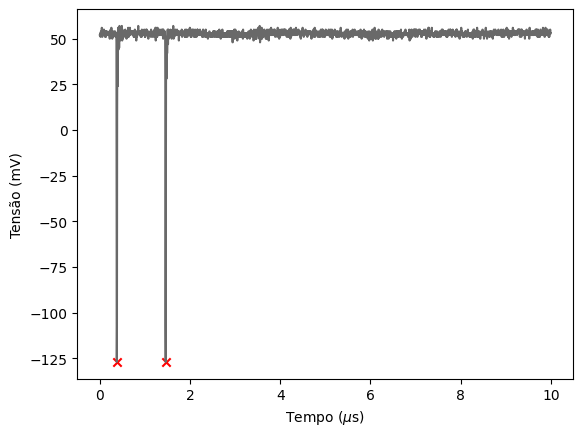

In [6]:
decay.plot_event(peaks_data=peaks.good[100])

In [7]:
time_diff = np.array([
    peaks.good[i].time_diff[0] \
    for i in range(len(peaks.good))
])

time_diff

array([4.068, 4.068, 4.068, ..., 6.572, 6.572, 6.572])

In [8]:
df_time_diff = pd.DataFrame(
    data    = time_diff, 
    columns = ["time_micro_sec"],
    index   = df.index,
)

df_time_diff.to_csv(path_or_buf="time_diff.csv", sep=",", index=False)

In [9]:
from scipy.optimize import curve_fit

def exp_function(x: float, a: float, tau: float, c: float) -> float:
    return a * np.exp(-x/tau) + c

In [10]:
hist, bin_edges = np.histogram(a=time_diff, bins="fd")
bin_centers = np.array([
    (bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1) 
])
popt, pcov = curve_fit(f=exp_function, xdata=bin_centers, ydata=hist)

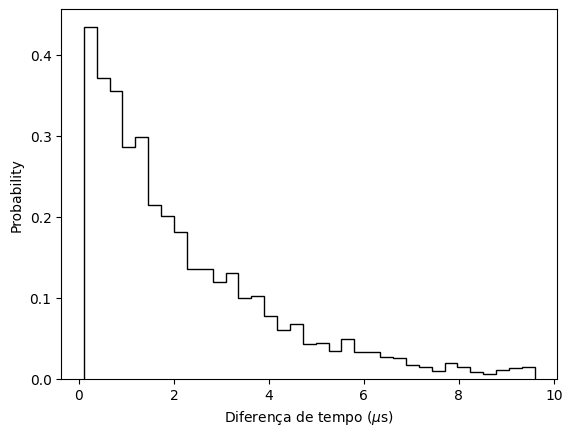

In [11]:
plt.hist(x=time_diff, density=True, bins="fd", color="black", histtype='step')
plt.xlabel(r"Diferença de tempo ($\mu$s)")
plt.ylabel('Probability')
plt.show()